# Federico Campanozzi - Progetto Data Intensive con Relazione
                                                                                                             a.a. 2021/2022

## 1 - Descrizione del problema

## 2- Analisi esplorativa

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
transactions = pd.read_csv("../data/data.csv")
transactions[:10]

In [ ]:
vMtx = transactions.describe().values
vMtx = np.vstack([vMtx, [len(transactions[c].unique()) for c in ["step","amount","oldbalanceOrg",
                                                                 "newbalanceOrig","oldbalanceDest","newbalanceDest",
                                                                 "isFraud","isFlaggedFraud"]]])
vMtx = np.vstack([vMtx, transactions.describe().isna().sum().values])
pd.DataFrame(data=vMtx,
             index=['count','mean','std','min','25%','50%','75%','max','valori distinti','valori nulli'],
             columns=transactions.describe().columns)

### 2.1 - Grafici

In [ ]:
plt.figure(figsize=(16, 10))
transactions["type"].value_counts().plot.pie(ax=plt.subplot(1, 3, 1));
transactions["isFraud"].value_counts().plot.pie(ax=plt.subplot(1, 3, 2));
transactions[transactions["isFraud"] == 1]["type"].value_counts().plot.pie(ax=plt.subplot(1, 3,3));

In [ ]:
feature_list = ["type","amount","oldbalanceOrg","newbalanceOrig"]
feature_numeric = ["amount","oldbalanceOrg","newbalanceOrig"]
feature_categorical = ["type"]

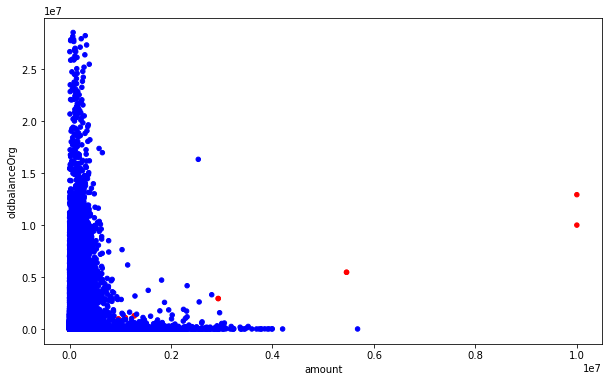

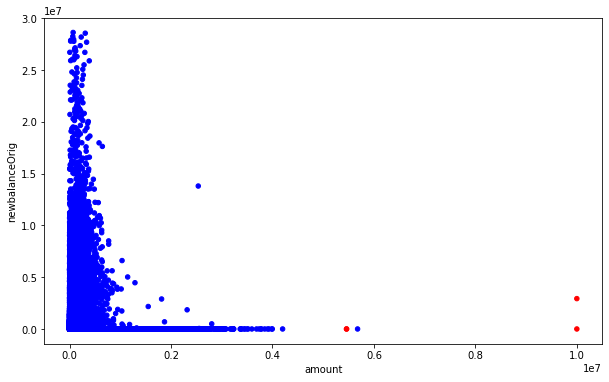

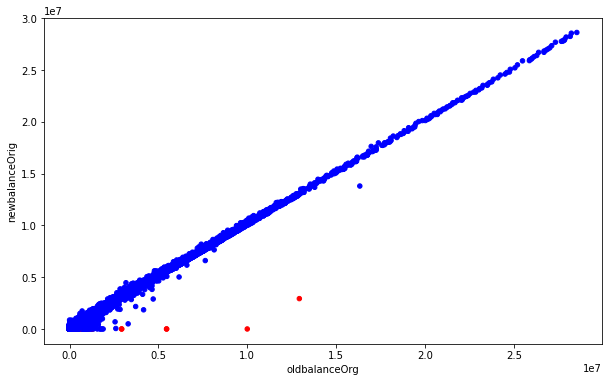

In [20]:
transactions = pd.read_csv("../data/data.csv", nrows=40_000)
tfraut_colors = transactions["isFraud"].map({0: "blue", 1: "red"})
for f_i in range(1,len(feature_list)):
     for f_j in range(f_i + 1, len(feature_list)) :        
        transactions.plot.scatter(feature_list[f_i], feature_list[f_j], c=tfraut_colors, figsize=(10, 6));

## 3 - Normalizzazione dei dati

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

X = transactions[feature_list]
y = transactions[["isFraud"]]

X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

preproc = ColumnTransformer(
    [
        ("numeric",StandardScaler(),feature_numeric),
        ("categorical",OneHotEncoder(),feature_categorical)
    ],remainder="drop")

X_sample = transactions[feature_numeric + feature_categorical]
preproc.fit_transform(X_sample)
pd.DataFrame(
    preproc.transform(X_sample),
    columns = feature_numeric + list(preproc.named_transformers_["categorical"].get_feature_names())
).head(10)

### 3.1 - PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

c_map = transactions[:X_train.values.shape[0]]["isFraud"].map({0: "blue", 1: "red"})
x_preproc = pca.fit_transform(preproc.fit_transform(X_train))

plt.scatter(x_preproc[:,0], x_preproc[:,1], c=c_map)
plt.xlabel('Asse latente X')
plt.ylabel('Asse latente Y')
plt.show()

## 4 - Modelli Predittivi

In [ ]:
from sklearn.pipeline import Pipeline
transactions = pd.read_csv("../data/data.csv", nrows=20_000)

Funzioni di base per il calcolo delle accuratezze

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, confusion_matrix, mean_squared_error

def print_matrix(classes, matrix, pad = 10):
    '''This method prints a matrix with better formatting.
    Is used for print n x n confusion matrix'''
    for i in range(len(classes)):
        if i == 0 : 
            for c in ([" "] + classes):
                print(f"{c.rjust(pad, ' ')}",end=' ')
            print()
        for j in range(len(classes)):
            if (j == 0) : 
                print(f"{classes[i].rjust(pad, ' ')}",end=' ')
            print(f"{str(matrix[i][j]).rjust(pad, ' ')}",end=' ')
        print()
    return None

def rmspe(y_real, y_pred):
    '''Root Mean Squared Percentage Error'''
    return np.sqrt(np.mean((y_pred /y_real - 1) ** 2))

def print_eval_regressor(X, y, model):
    '''print eval for regression model'''
    y_pred = model.predict(X)
    print(f"MSE       : {mean_squared_error(y, y_pred):12.4f}")    
    print(f"RMSPE     : {rmspe(y.values, y_pred):12.4f}")
    print_eval_base(X, y, model)
    return None

def print_eval_classify(X, y, model, classes):
    '''print eval for classification model'''
    y_pred = model.predict(X)    
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix : ")
    print_matrix(classes, cm)
    print(f"\nPRECISION  : {precision_score(y, y_pred):12.4f}")
    print(f"RECALL     : {recall_score(y, y_pred):12.4f}")
    print(f"F1-MEASURE : {f1_score(y, y_pred, average='macro'):12.4f}")
    print_eval_base(X, y, model)
    return None

def print_eval_base(X, y, model):
    '''print eval for all model, only R^2 score '''
    y_pred = model.predict(X)
    print(f"R^2 : {r2_score(y, y_pred):12.4f}")
    return None

def plot_separator_on_data(X, y, model=None):
    '''plot data into 2d space'''
    c_map = transactions[:X.values.shape[0]]["isFraud"].map({0: "blue", 1: "red"})
    X = np.array(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=c_map)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        sep_x = np.linspace(*xlim, 2)
        sep_y = separator_2d(model, sep_x)
        plt.plot(sep_x, sep_y, c="green", linewidth=2)
        plt.xlim(xlim); plt.ylim(ylim)
    return None

def separator_2d(model, x1):
    '''draw a 2d line based his equation'''
    w = model.coef_[0]
    b = model.intercept_[0]
    return -x1 * w[0] / w[1] - b / w[1]

## 4.1 - Modelli di Regressione 

### 4.1.1 - Ridle Regression

In [ ]:
from sklearn.linear_model import Ridge

model = Pipeline([
    ("preproc", preproc),
    ("regRidge", Ridge(alpha=1))
])

model.fit(X_train, y_train)
print_eval_regressor(x_val, y_val, model)

## 4.2 Alberi di Regressione 
##### (XGBRegressor, Lightgbm (Random Forest), Catboost)

In [ ]:
from xgboost import XGBRegressor

xgbm = XGBRegressor(objective='reg:squarederror', 
                    learning_rate = 0.01577, 
                    reg_lambda=0.008, 
                    reg_alpha=0.0001, 
                    n_estimators=1025, 
                    verbose_eval=False)
model = Pipeline([
    ("preproc", preproc),
    ("XGBRegressor", xgbm)
])
model.fit(X_train, y_train)
print_eval_regressor(x_val, y_val, model)

In [ ]:
from lightgbm import LGBMRegressor

model = Pipeline([
    ("preproc",preproc),
    ("LGBM", LGBMRegressor(boosting_type='rf',n_estimators=1000,max_depth=-1,bagging_freq =10,bagging_fraction=0.95))
])

model.fit(X_train, y_train)
print_eval_regressor(x_val, y_val, model)

In [ ]:
from catboost import CatBoostRegressor

model = Pipeline([
    ("preproc", preproc),
    ("CATBOOST", CatBoostRegressor(n_estimators=91))
])

model.fit(X_train, y_train);
print_eval_regressor(x_val, y_val, model)

Come possiamo vedere anche gli alberi di regressione non funzionano bene.

## 4.3 Modelli di Classificazione

### 4.3.1 Alberi Decisionali

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

classes = ["isFraud", "Honest"]

model = Pipeline([
    ("preproc", preproc),
    ("decisionTree", DecisionTreeClassifier(max_depth=5,random_state=43))
])

model.fit(X_train, y_train)
print_eval_classify(x_val, y_val, model, classes)

plt.figure(figsize=(22, 6))
plot_tree(model.named_steps["decisionTree"], max_depth=5, filled=True, fontsize=8);

### 4.3.2 - Logistic Loss

In [ ]:
from sklearn.linear_model import LogisticRegression

model_RegLos = Pipeline([
    ("preproc", preproc),
    ("RegLoss", LogisticRegression(solver="saga", random_state=11, class_weight={1:45}))
])

model_RegLos.fit(X_train, y_train)

print_eval_classify(x_val, y_val, model, classes)

Di seguito voglio creare un modello, uguale al precedente, con solo due feature per cercare di far capire
come vengono fatti gli split e come l'algoritmo divide lo spazio.
Non posso farlo con tutte le feature perchè sono > 2

C:\Users\Federico\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Confusion Matrix : 
              isFraud     Honest 
   isFraud      13286         11 
    Honest         35          2 

PRECISION  :       0.1538
RECALL     :       0.0541
F1-MEASURE :       0.5391
R^2 :      -0.2467


C:\Users\Federico\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


<Figure size 1584x432 with 0 Axes>

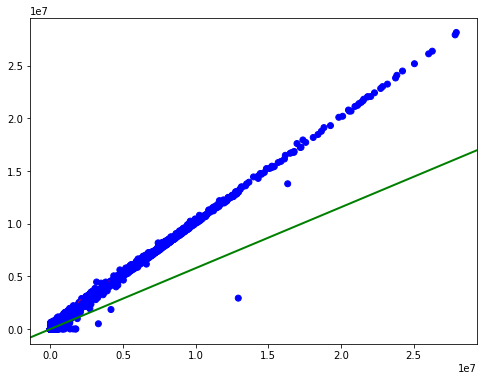

In [56]:
X_dt = transactions[["oldbalanceOrg","newbalanceOrig"]]
y_dt = transactions[["isFraud"]]

X_train_dt, x_val_dt, y_train_dt, y_val_dt = train_test_split(X_dt, y_dt, test_size=1/3, random_state=42)

model_dt = Pipeline([
    ("preproc", StandardScaler()),
    ("RegLoss", LogisticRegression(solver="saga", random_state=42, class_weight={1:45}))
])

model_dt.fit(X_train_dt, y_train_dt)
print_eval_classify(x_val_dt, y_val_dt, model_dt, classes)

plt.figure(figsize=(22, 6))

plot_separator_on_data(x_val_dt, y_val_dt, model_dt.named_steps["RegLoss"]);

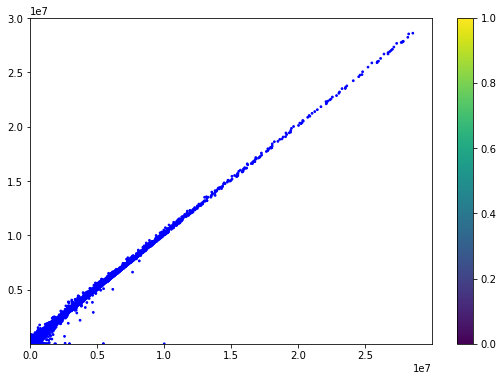

In [63]:
mx1, mx2 = np.meshgrid(np.linspace(0, 2700, 100), np.linspace(0, 0.22, 100))
my = model_dt.predict_proba(np.c_[mx1.ravel(), mx2.ravel()])[:, 1].reshape(mx1.shape)
c_map = transactions[:X_train_dt.values.shape[0]]["isFraud"].map({0: "blue", 1: "red"})
plt.figure(figsize=(9, 6))
plt.contourf(mx1, mx2, my, cmap="summer")
plt.scatter(*X_train_dt.values.T, c=c_map, s=3)
plt.colorbar();

### 4.3.3 XGBClassifier

In [ ]:
from xgboost import XGBClassifier 

xgbm_c = XGBClassifier(objective='reg:squarederror', 
                    learning_rate = 0.01577, 
                    reg_lambda=0.008, 
                    reg_alpha=0.0001, 
                    n_estimators=1025, 
                    verbose_eval=False)
model = Pipeline([
    ("preproc", preproc),
    ("XGBClassifier", xgbm_c)
])
model.fit(X_train, y_train)

print_eval_classify(x_val, y_val, model, classes)

### 4.3.4 Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

model_svm = Pipeline([
    ("preproc", preproc),
    ("SVM", SVC(kernel='rbf',random_state=42))
])

model_svm.fit(X_train, y_train)

print_eval_classify(x_val, y_val, model, classes)

## 4.4 - Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X_nn = transactions[["type","amount","oldbalanceOrg","newbalanceOrig"]]
y_nn = transactions[["isFraud"]]
X_train_nn, x_val_nn, y_train_nn, y_val_nn = train_test_split(X_nn, y_nn, test_size=1/3, random_state=42)

X_scaler = ColumnTransformer([
        ("numeric",StandardScaler(),["amount", "oldbalanceOrg", "newbalanceOrig"]),
        ("categorical",OneHotEncoder(),["type"])
    ],remainder="drop")

Y_scaler = StandardScaler()

X_train_nn = X_scaler.fit_transform(X_train)
x_val_nn = X_scaler.transform(x_val)
y_train_nn = Y_scaler.fit_transform(y_train)
y_val_nn = Y_scaler.transform(y_val.values)

model_nn = Sequential([
    Dense(8, activation="relu", input_dim=8),
    Dense(1)
])
model_nn.summary()
model_nn.compile(optimizer="adam",loss="mean_squared_error")
fit_history = model_nn.fit(X_train_nn, y_train_nn, batch_size=10, epochs=15)
print_eval_base(x_val_nn, y_val_nn, model_nn)

In [ ]:
plt.plot(fit_history.history["loss"], "ro-")
plt.legend(["Loss (Mean Square Error)"])
plt.xlabel("Epochs");

In [ ]:
def build_nn(nodes, inpDim):
    model = Sequential([
        Dense(nodes, activation="relu", input_dim=inpDim),
        Dense(256, activation="softmax"),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    model.summary()
    return model

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

model_nn = Pipeline([
    ("preproc", preproc),
    ("NN", KerasRegressor(build_fn=build_nn, nodes=512, inpDim=8, epochs=20, batch_size=1000))
])
model_nn.fit(X_train, y_train)
print_eval_base(x_val, y_val, model_nn)

## 5 - Tuning degli Iperparametri

Per questa parte utilizziamo una porzione più ampia del datataset

In questa parte andremo ad suddividere il dataset in 3 parti e le useremo nel seguente modo :
   - Training Set : Per addestrare i modelli
   - Validation Set : Per vericare l'accuratteza dei modelli su dati mai visti in fase di training
   - Test Set : Per calcolare la confidenza

In [60]:
from sklearn.model_selection import GridSearchCV, KFold
kf = KFold(3, shuffle=True, random_state=42)

transactions = pd.read_csv("../data/data.csv", nrows=200_000)
X = transactions[feature_list]
y = transactions[["isFraud"]]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=1/3, random_state=42)

I modelli che meglio si sono comportati per questo esperimento sono stati, come ci si poteva aspettare,
i modelli di classificazione. Andiamo quindi a cercare i migliori iperparametri per i seguenti modelli : 
 - Alberi Decisionali
 - Logistic Loss
 - Support Vector Machines (SVM)

In [ ]:
grid = {
    "XGBoost__learning_rate": [0.01577,0.001577,0.01477,0.04577]
}

gs = GridSearchCV(model_XGBoost, grid, cv=kf)
gs.fit(X_train, y_train);

In [ ]:
grid = {
    "SVM__degree": [3, 4],
    "SVM__kernel": ['linear', 'poly', 'rbf']
}

gs = GridSearchCV(model_svm, grid, cv=kf)
gs.fit(X_train, y_train);

In [ ]:
grid = {
    "SVM__degree": [3, 4],
    "SVM__kernel": ['linear', 'poly', 'rbf']
}

gs = GridSearchCV(model_svm, grid, cv=kf)
gs.fit(X_train, y_train);

## 6 - Conclusioni 

Possiamo stimare l'accuratezza sui nuovi dati con un processo Bernoulliano :

In [ ]:
def bernoulli_process(confidence) :
    z = 
    f = S / N
    p_ub = (f + z**2/(2*N) + z*np.sqrt(f/N - f**2/N + z**2/4*N**2)) / (1+z**2/N)
    p_lb = (f + z**2/(2*N) - z*np.sqrt(f/N - f**2/N + z**2/4*N**2)) / (1+z**2/N)
    return p_ub, p_lb

## 7 - Deployment

In [ ]:
Il modello poi può essere utilizzato da una web-app oppure una applicazione mobile 

## 8- Link alle risorse
#### Link al dataset di kaggle
https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset